In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, LearningCurveDisplay, learning_curve, validation_curve
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score
)


from utils import get_data, get_df_details, plot_distrb, make_confusion_matrix

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
X = pd.read_csv('data/CC GENERAL.csv')
X.drop(columns=['CUST_ID'], inplace=True)
X.ffill(inplace=True)
X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
# Split data into train and test sets.

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, _, _ = train_test_split(X, X, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [5]:
num_cols = X.columns

# Train the Expectation Maximisation

In [6]:
RANDOM_STATE = 42
# N_FOLDS = 5
N_JOBS = -1
VERBOSE = 4


# Use minmax scaler for simplicity, scalability, avoids assumption of distribution and there are no outliers in data
num_pipeline = Pipeline(steps=[
    # ('scale', MinMaxScaler()),
    ('scale', StandardScaler())
])
# cat_pipeline = Pipeline(steps=[
#     ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False))
# ])

col_trans = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, num_cols),
        # ('cat_pipeline', cat_pipeline, cat_cols)
        ],
    remainder='drop',
    n_jobs=N_JOBS)

# For KMeans use the default algo, max_iterations, init='k-means++'
# clus = GaussianMixture(n_init=100, init_params='k-means++', random_state=RANDOM_STATE, covariance_type='full')
clus = GaussianMixture(random_state=RANDOM_STATE)
clus_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clus)
])


In [61]:
# from sklearn.decomposition import PCA
# scaler = StandardScaler() 
# scaled_df = scaler.fit_transform(X_train) 
  
# # Normalizing the Data 
# normalized_df = normalize(scaled_df) 
  
# # Converting the numpy array into a pandas DataFrame 
# normalized_df = pd.DataFrame(normalized_df) 
# pca = PCA(n_components = 2) 
# X_principal = pca.fit_transform(normalized_df) 
# X_principal = pd.DataFrame(X_principal) 
# X_principal.columns = ['P1', 'P2'] 

# gmm = GaussianMixture(n_components = 2) 
# gmm.fit(X_principal)

# print(gmm.aic(X_principal))
# print(gmm.bic(X_principal))

GaussianMixture(n_components=2)

In [7]:
clus_pipeline.set_params(model__n_components=3)
clus_pipeline.fit(X_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object'))])),
                ('model', GaussianMixture(n_components=3, random_state=42))])

In [8]:
print(clus_pipeline.named_steps['model'].aic(X_train))
print(clus_pipeline.named_steps['model'].bic(X_train))

495562130870121.06
495562130873641.7


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(


In [16]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    clus_pipeline.set_params(model__n_components=n_components)
    clus_pipeline.fit(X_train)
    
    # clus_labels = clus_pipeline.named_steps['model'].labels_
    # sil_score = silhouette_score(X_train, clus_labels)
    
    results[n_components] = {'aic': clus_pipeline.named_steps['model'].aic(X_train.values),
                             'bic': clus_pipeline.named_steps['model'].bic(X_train.values),
                             # 'sil_score': sil_score
                           }

---------- n_components: 2 ----------
---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


In [17]:
print(results)

{2: {'aic': 141698677528003.3, 'bic': 141698677530348.12}, 3: {'aic': 495562130870121.06, 'bic': 495562130873641.7}, 4: {'aic': 408345216504158.5, 'bic': 408345216508855.0}, 5: {'aic': 1428419085006405.0, 'bic': 1428419085012277.2}, 6: {'aic': 288689142591285.75, 'bic': 288689142598333.94}, 7: {'aic': 274303943069045.84, 'bic': 274303943077269.84}, 8: {'aic': 349768757513735.25, 'bic': 349768757523135.1}, 9: {'aic': 97610147197196.78, 'bic': 97610147207772.48}, 10: {'aic': 93351693849289.22, 'bic': 93351693861040.75}, 11: {'aic': 78869812014065.94, 'bic': 78869812026993.31}, 12: {'aic': 91027728939603.06, 'bic': 91027728953706.28}, 13: {'aic': 596467428030484.6, 'bic': 596467428045763.6}, 14: {'aic': 203967669981332.2, 'bic': 203967669997787.1}, 15: {'aic': 258218658131298.2, 'bic': 258218658148928.94}, 16: {'aic': 116854615531575.8, 'bic': 116854615550382.38}, 17: {'aic': 98843090089572.22, 'bic': 98843090109554.64}, 18: {'aic': 107287367757909.83, 'bic': 107287367779068.1}, 19: {'aic

<Axes: title={'center': 'BIC'}, xlabel='n_components'>

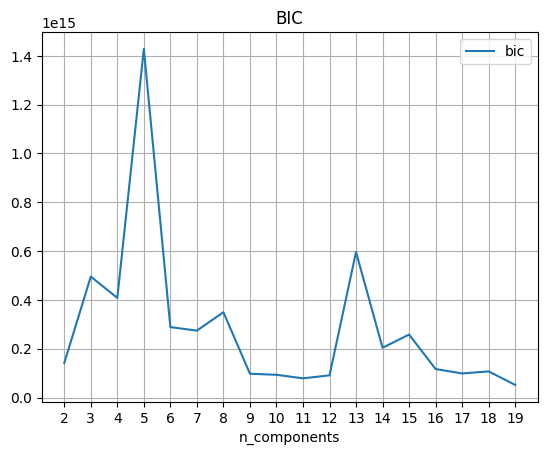

In [23]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic']
results_df.plot(x='n_components', y='bic',title='BIC', xticks=results_df['n_components'], grid=True)

# Tune the KMeans

In [67]:
# # https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/
# # 

# cv_scores = []

# grid_params = {
#         'n_clusters': {'model__n_clusters': np.arange(2,21)}, 
#         'n_init': {'model__n_init': np.arange(5, 55, 5)},
#         'init': {'model__init': ['k-means++', 'random']},
#         'max_iter': {'model__max_iter': np.arange(100, 1000, 100)},
#     }
# for key, grid_param in grid_params.items():
#     print('------------------', key, '------------------')
    
#     gs = GridSearchCV(clus_pipeline, grid_param, 
#                       cv=N_FOLDS, scoring=silhouette_score, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True,
#                      refit=True)
#     gs.fit(X_train)

#     cv_scores.append(pd.DataFrame({'param': [key]*len(gs.cv_results_['mean_test_score']),
#                                    'value': gs.cv_results_[f'param_{list(grid_param.keys())[0]}'],
#                                    'mean_test_score': gs.cv_results_['mean_test_score'],
#                                    'mean_train_score': gs.cv_results_['mean_train_score']}))

# cv_scores = pd.concat(cv_scores)

------------------ n_clusters ------------------
Fitting 5 folds for each of 19 candidates, totalling 95 fits


C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
  warnings.warn(
C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
  warnings.warn(


------------------ n_init ------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


------------------ init ------------------
Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(
C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [nan nan]
  warnings.warn(


------------------ max_iter ------------------
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


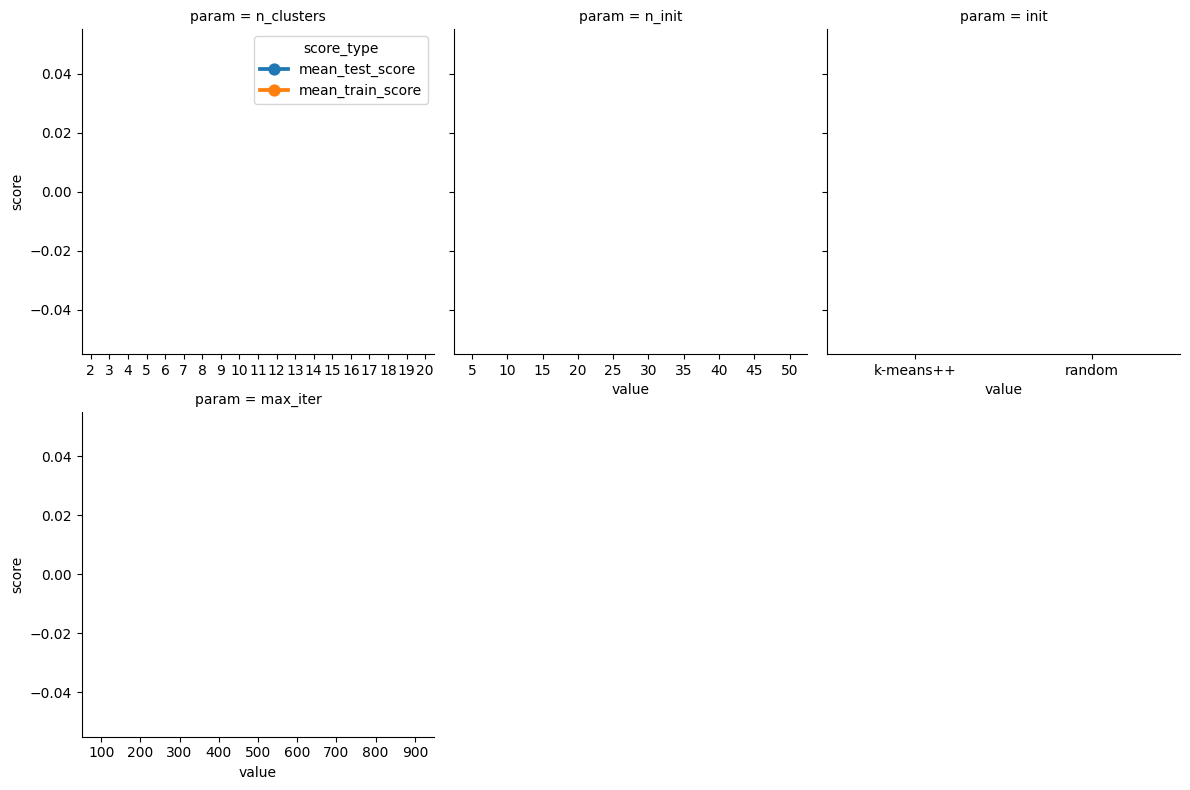

In [68]:
# cv_scores_melt = cv_scores.melt(id_vars=['param', 'value'], value_vars=['mean_test_score', 'mean_train_score'], var_name='score_type', value_name='score')
# sns.FacetGrid(cv_scores_melt, col='param', hue='score_type', col_wrap=3, height=4, sharex=False, legend_out=False).map(sns.pointplot, 'value', 'score').add_legend()

In [ ]:
# grid_params = {
#         'model__n_neighbors': np.arange(35, 50, 5), 
#         'model__metric':['minkowski', 'manhattan', 'euclidean'],
#     }

    
# gs = GridSearchCV(clf_pipeline, grid_params, 
#                     cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
# gs.fit(X_train, y_train.values.ravel())

# print("Best Score of train set: "+str(gs.best_score_))
# print("Best parameter set: "+str(gs.best_params_))
# print("Test Score: "+str(gs.score(X_test,y_test)))

In [ ]:
gs.best_estimator_['model']

In [ ]:
import joblib
joblib.dump(value=gs, filename='./model/kmeans_dry_bean_ppl.pkl', compress=True)
joblib.dump(value=gs.best_estimator_, filename='./model/kmeans_dry_bean_ppl.pkl', compress=True)

In [ ]:
# Plot learning curve of the best model from grid search
train_size_abs, train_scores, test_scores = \
    learning_curve(gs.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=N_FOLDS, n_jobs=N_JOBS, scoring=SCORING, verbose=VERBOSE)

In [ ]:
plot_df = pd.DataFrame({'train_size_abs': train_size_abs, 
                        'mean_train_scores': np.mean(train_scores, axis=1), 
                        'mean_test_scores': np.mean(test_scores, axis=1)})
plot_df = plot_df.melt(id_vars='train_size_abs', value_vars=['mean_train_scores', 'mean_test_scores'])
sns.pointplot(plot_df, x='train_size_abs',y ='value', hue='variable')

In [ ]:
# Get the score of the best model on test

# gs.best_estimator_ is the best model found by GridSearchCV
y_test_predictions = gs.predict(X_test)
# Generate confusion matrix for the predictions from the best model
conf_matrix = confusion_matrix(y_test, y_test_predictions)

make_confusion_matrix(conf_matrix, group_names=['True Neg','False Pos','False Neg','True Pos'], categories=['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'], cmap='Blues')

In [ ]:
# target_names=target_names
print(classification_report(y_test, y_test_predictions))